# Computational Analysis of Rupi Kaur's Poetry & Reader Response

Hannah Shlesinger

Dr Adam Anderson

Digital Humanities 100

Summer 2021

### Research Questions

The code below uses computational techniques to compare Rupi's three collections of poetry, *Milk and Honey* (2014), *The Sun and Her Flowers* (2017), and *Homebody* (2020) to answer the following questions:

1. What are the most popular themes and defining features in Rupi Kaur's poetry?  

2. How have online 'book community' (specifically Goodreads users) responded to her work over time?

# Install & Import Relevant Libraries

In [359]:
#i commented these out since I already downloaded them but you can uncoment to install the relevant libraries
#!pip install gensim
#!pip install wordcloud
#!pip install pyldavis
#!pip install contractions
 
#you need to install -U pandas-profiling if you're running this notebook through colab otherwise the pandas df won't print for you
 #!pip install -U pandas-profiling

In [360]:
#imports for Sentiment Analysis 
import re
import spacy
import os
import string
import math
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#natural language toolkit
import nltk 
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from string import punctuation
from collections import Counter
nltk.download('wordnet')
nltk.download('punkt') 

#import contractions library
import contractions

#Vader Sentiment analysis
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.core.display import Image, display

#plot set up
mpl.rc('savefig', dpi=200)
plt.style.use('fivethirtyeight')
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.minor.size'] = 1
sns.set(style = "whitegrid", color_codes = True, font_scale = 1.5)


#imports for wordclouds & LDA
from collections import Counter # Count most common words
import gensim # word2vec model
import pyLDAvis.sklearn # visualize our topic models!
import re # regular expressions
import seaborn as sns
# CV (multiple train/test splitting)
from sklearn.model_selection import cross_val_score, train_test_split
# Algorithms (unsupervised)
from sklearn.decomposition import LatentDirichletAllocation, PCA
# (supervised)
from sklearn.linear_model import LogisticRegression
# Tools to create our DTMs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
# Speed up your machine learning setup
from sklearn.pipeline import Pipeline
# Mix up our training and test sets
from sklearn.utils import shuffle
# Super awesome NLP library
import spacy
# Visualize word clouds 
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)





[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hannahshlesinger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hannahshlesinger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part 1: Computational Text Analysis of Rupi Kaur's Poetry

## Data and Text Files  

I got pdfs of Kaur's work from a few different places, notably
<a href="https://archive.org
">The Internet Archive</a> 

All files can be found in the 'Data' file in the 'Final Project' folder



In [4]:
#make sure you're in the right working directory 
cwd = os.getcwd()
os.chdir('/Users/hannahshlesinger/Desktop/DIGHUM101-2021-main/Final Project/Data')
cwd


'/Users/hannahshlesinger/Desktop/DIGHUM101-2021-main/Final Project'

In [5]:
#reading in text files 

milkhoney_path = "milk-and-honey.txt"
sunflowers_path = "sun-and-flowers.txt"
homebody_path = "home-body.txt"

#come back and rerun the notebook with start and end where poems actually begin in each respective text
#start = milkhoney_path.find("THE GOLD-BUG")
#end = poeString.find("FOUR BEASTS IN ONE")
#goldBugString = poeString[start:end]


milkhoney = open(milkhoney_path, encoding="utf-8").read()
sunflowers = open(sunflowers_path, encoding="utf-8").read()
homebody = open(homebody_path, encoding = "utf-8").read()

texts = ([["Milk and Honey", 2014, milkhoney], 
          ["The Sun and Her Flowers", 2017, sunflowers], 
          ["Homebody", 2020, homebody,]])
         

In [6]:
#how many stanzas in milk and honey?
m_stanzas = len(milkhoney.split('\n\n'))
print("Milk and Honey:", "\n", m_stanzas)
print(len(milkhoney.split('\n')))

print('\n')
#how many stanzas in the sun and her flowers?
s_stanzas = len(sunflowers.split('\n\n'))
print("The Sun and her flowers:", "\n", s_stanzas)
print(len(sunflowers.split('\n')))

print('\n')
#how many stanzas in homebody?
h_stanzas = len(homebody.split('\n\n'))
print("Homebody:", "\n", h_stanzas)
print(len(homebody.split('\n')))

print('\n')
#how many stanzas in total
print("Total:", "\n", m_stanzas + s_stanzas + h_stanzas)

Milk and Honey: 
 182
1435


The Sun and her flowers: 
 228
2471


Homebody: 
 176
1468


Total: 
 586


So we know we're working with a decent amount of poems, keeping in mind that *the sun and her flowers* is kaur's biggest collection

In [7]:
#create pandas data frame of entire collections 
text_df = pd.DataFrame(texts, columns=["title", "publish_date", "raw_text"])
text_df

,title,publish_date,raw_text
0,Milk and Honey,2014,how is it so easy for you\nto be kind to peopl...
1,The Sun and Her Flowers,2017,bees came for honey\nflowers giggled as they\n...
2,Homebody,2020,after feeling disconnected for so long\nmy m...


# Part of Speech Analysis

I am using this <a href="https://nbviewer.jupyter.org/github/sgsinclair/alta/blob/master/ipynb/PartsOfSpeech.ipynb">Jupytr tutorial</a> as a guide for how to do and visualize my POS analysis

For this section, I am using the raw text files converted from pdfs instead of the csv dataframe 

## Processing the text

Before we tag the text, we should normalize it. The first step is to convert the 'raw_text' data column into a string.

In [8]:
#convert the raw-text column into a string variable 
long_string = ','.join(text_df["raw_text"].values)

#let's see how it looks
long_string[0:200]

'how is it so easy for you\nto be kind to people he asked\nmilk and honey dripped\nfrom my lips as i answered\ncause people have not\nbeen kind to me\n\n\x0cthe first boy that kissed me\nheld my shoulders down\nli'

In [9]:
#how many characters do we have in our string?
len(long_string)

135089

I am using <a href="https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/">NLP</a> to expand contractions into their full parts as seen in part of the code below

In [10]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [306]:
#remove punctuation 
for char in punctuation:
    long_string = long_string.replace(char, "")
    
#remove contractions
expanded_words = []    
for word in long_string.split():
 # using contractions.fix to expand the shotened words
  expanded_words.append(contractions.fix(word))   
    
expanded_string = ' '.join(expanded_words)

#make lowercase
expanded_string = expanded_string.lower()

#remove digits using regex
digits = r'[0-9]'

expanded_text_string = re.sub(digits, '', expanded_string)

expanded_text_string[60:800]

' and honey dripped from my lips as i answered because people have not been kind to me the first boy that kissed me held my shoulders down like the handlebars of the first bicycle he ever rode i was five he had the smell of starvation on his lips which he picked up from his father feasting on his mother at  am he was the first boy to teach me my body was for giving to those that wanted that i should feel anything less than whole and my god did i feel as empty as his mother at  am it is your blood in my veins tell me how i am supposed to forget the therapist places the doll in front of you it is the size of girls your uncles like touching point to where his hands were you point to the spot between its legs the one he fingered out of'

In [307]:
#how many characters do we have in our string now?
len(expanded_string)

133640

In [308]:
#for some reason, my commas weren't being deleted
expanded_string = expanded_string.replace("\'", "")
expanded_string[:100]

'how is it so easy for you to be kind to people he asked milk and honey dripped from my lips as i ans'

In [309]:
expanded_string = "".join(c for c in expanded_string if c not in ("?", ".", ";", ":", "!", "‘", "’","\'"))

In [310]:
#tokenize our words
tokens = expanded_string.split()

#let's remove stopwords
stop = stopwords.words('english')
tokens = [word for word in tokens if word not in stopwords.words(
'english')]

print(tokens[:10])

['easy', 'kind', 'people', 'asked', 'milk', 'honey', 'dripped', 'lips', 'answered', 'people']


In [311]:
#tokenize the words in expanded_string
text_tokens = nltk.word_tokenize(expanded_string) 

#remove stop words from token list
stop = stopwords.words("english")
text_tokens = [word for word in text_tokens if word not in stopwords.words('english')]


print(text_tokens[:10])

['easy', 'kind', 'people', 'asked', 'milk', 'honey', 'dripped', 'lips', 'answered', 'people']


### Wordcloud Visualization of common words

before we look more specifically at the parts of speech, let's look at a WordCloud to get a quick sense of the most common words in Rupi Kaur's poetry

In [312]:
#uncomment to view the common stop words in the 'english' dictionary
#stopwords.words('english')

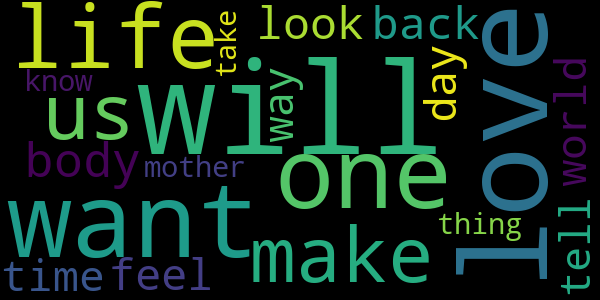

In [332]:
# Define a word cloud variable
#I'm only displaying the top 20 words so it doesn't get too crowded
cloud = WordCloud(background_color = "black", 
                  max_words = 20, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 5)

# Process the word cloud
cloud.generate(expanded_string)

# Visualize!
cloud.to_image()

### Graph Visualizations of Common Words

Another useful way to visualize with context of numbers is a simple bar chart. With a WordCloud, you can't tell exactly how much the frequency differs between the words. 

In [333]:
freq_text_tokens = Counter(text_tokens)
freq_text_tokens
freq_text_tokens_df = pd.DataFrame(freq_text_tokens.most_common(10), columns = ['Word', 'Frequency'])
freq_text_tokens_df

,Word,Frequency
0,like,161
1,love,138
2,want,99
3,would,97
4,life,94
5,one,87
6,us,77
7,body,68
8,could,59
9,back,58


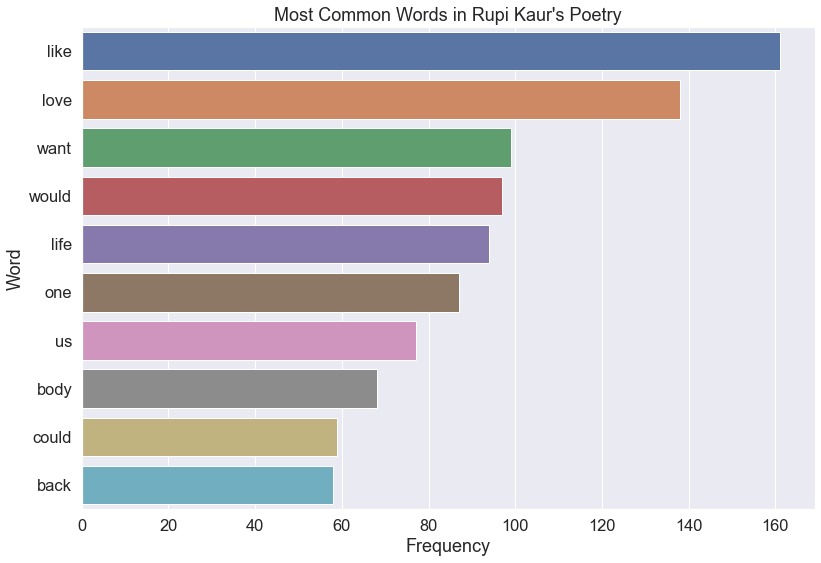

In [334]:
# Visualize word frequencies in a horizontal bar plot
sns.barplot(x = "Frequency",
            y = "Word",
            data = freq_text_tokens_df,
            orient = "h").set_title("Most Common Words in Rupi Kaur\'s Poetry");

### Lemmatization

Lemmatizing them will break the text into a list of stems of all the words

In [316]:
#to do so, we will be using Natural Langauge Processesing pretrained model 

# Load the small pretrained model since our data set is pretty small
nlp = spacy.load('en_core_web_sm')

In [318]:
# Define our function 
def lemmatize(text_tokens):
    """Return the lemmas for each word in `tokens`."""
    # convert the token list back into a string
    words = ' '.join(text_tokens)
    # this line does all sorts of processing, including the lemmatization.
    # `doc` will be like a list of tokens that we can iterate over
    doc = nlp(words)
    # each token in `doc` holds information about that token. The `lemma_`
    # attribute holds the lemma of that token represented as a string. For
    # performance reasons, the `lemma` (without the trailing underscore) holds
    # an integer representation of the token, that we'll rarely ever need.
    return [token.lemma_ for token in doc]

lemmas = lemmatize(text_tokens)

lemmas[:10]

['easy',
 'kind',
 'people',
 'ask',
 'milk',
 'honey',
 'drip',
 'lip',
 'answer',
 'people']

In [319]:
doc = nlp(" ".join(lemmas))
    

d = []
for token in doc:
    d.append((token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
          token.shape_, token.is_alpha, token.is_stop))

out = pd.DataFrame(d, columns=("text", "lemma", "pos", "tag", "dep", "shape", 
                               "is_alpha", "is_stop"))

#is_stop tells us if the word is a stop word
#is_alpha tells us if the word consists of alphabetic characters


out.head()


,text,lemma,pos,tag,dep,shape,is_alpha,is_stop
0,easy,easy,ADJ,JJ,amod,xxxx,True,False
1,kind,kind,NOUN,NN,nsubj,xxxx,True,False
2,people,people,NOUN,NNS,nsubj,xxxx,True,False
3,ask,ask,VERB,VBP,relcl,xxx,True,False
4,milk,milk,NOUN,NN,compound,xxxx,True,False


In [327]:
#what does this chart tell us exactly?
out.describe()

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop
count,11835,11835,11835,11835,11835,11835,11835,11835
unique,2528,2503,16,30,39,12,2,2
top,like,like,NOUN,NN,compound,xxxx,True,False
freq,166,166,5459,5597,2486,10277,11740,9527


## Adjectives

Below, I identify and plot the most common adjectives "JJ" in Kaur's poetry

In [163]:
text_tagged = nltk.pos_tag(text_tokens)
text_tagged[:10]

[('easy', 'JJ'),
 ('kind', 'NN'),
 ('people', 'NNS'),
 ('asked', 'VBD'),
 ('milk', 'NN'),
 ('honey', 'NN'),
 ('dripped', 'VBD'),
 ('lips', 'NNS'),
 ('answered', 'JJ'),
 ('people', 'NNS')]

In [335]:
# What are the most common adjectives?
text_adj = [token for token, pos in text_tagged if "JJ" == pos]
text_adj_freq = nltk.FreqDist(text_adj)
adj_df = pd.DataFrame(text_adj_freq.most_common(20), columns = ["Adjective", "Frequency"])
adj_df.head()

,Adjective,Frequency
0,much,33
1,first,29
2,beautiful,29
3,enough,21
4,good,20


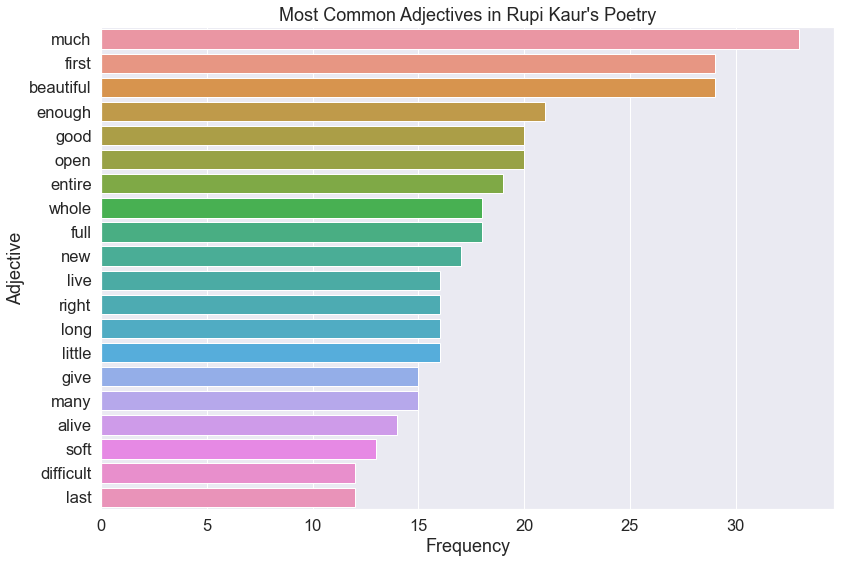

In [297]:
# Visualize word frequencies in a horizontal bar plot
sns.barplot(x = "Frequency",
            y = "Adjective",
            data = adj_df,
            orient = "h").set_title("Most Common Adjectives in Rupi Kaur\'s Poetry");

## Uh ohs

As you can see, some of these words aren't adjectives or probably aren't being used as adjectives like 'live' and 'give.' NLTK isn't perfect, but even from this initial tokenization and tagging, we can identify key descriptors that Rupi uses. 

We will likely run into more 'uh ohs' as we go along

### What can these adjectives tell us?

I will be running Kaur's work through a sentiment analysis later on to see how 'positive' or 'negative' her work scores, but from this graph alone, it is interesting to see how positive these words seem to be. In particular, 'first' and 'beautiful' stand out. 

Perhaps this indicates that Kaur's work has a lot to do with first experiences, indicating to an extent that her content may relate to coming of age experiences. The word 'beautiful' could indicate a lot of things but does seem to promote the aesthetic value of subjects or objects within her work even if we don't know the exact context the adjective is being used in. 

## Nouns

Below, I identify and plot the most common nouns "NN" in Kaur's work 

In [336]:
# What are the most common adjectives?
text_noun = [token for token, pos in text_tagged if "NN" == pos]
text_noun_freq = nltk.FreqDist(text_noun)
noun_df = pd.DataFrame(text_noun_freq.most_common(20), columns = ["Noun", "Frequency"])
noun_df.head()

,Noun,Frequency
0,life,94
1,body,62
2,time,54
3,nothing,48
4,way,47


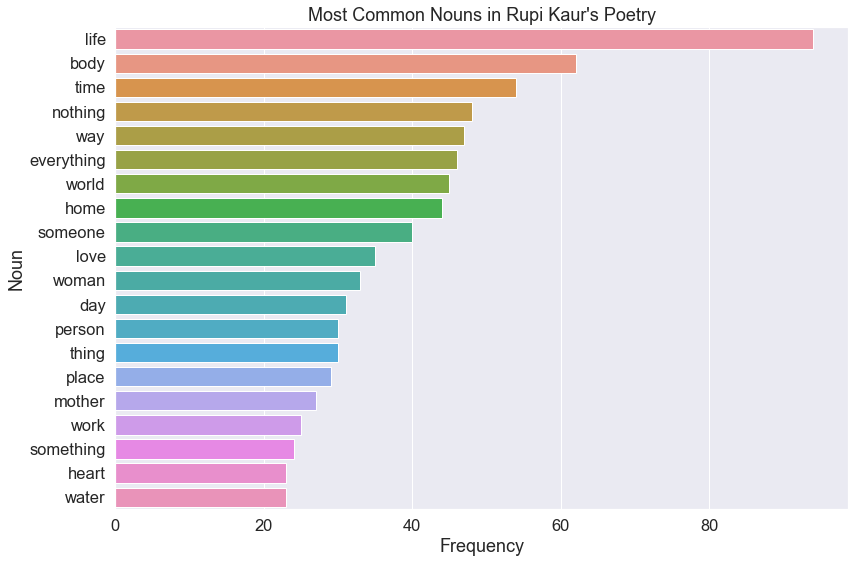

In [295]:
# Visualize word frequencies in a horizontal bar plot
sns.barplot(x = "Frequency",
            y = "Noun",
            data = noun_df,
            orient = "h").set_title("Most Common Nouns in Rupi Kaur\'s Poetry");

### What can nouns tell us? 
Again, it is staggering to see just how much 'life' and 'body outstand all the rest of nouns in Kaur's work. Of course, we should keep in mind that one of her works is titled 'homebody,' but still it is clear from the data that 'the body' is of huge importance. That both 'woman' and 'women' show up in the top 20 words indicate that Kaur is perhaps discussing themes of the body specific to womanhood. 



## Verb Phrases
Below, I identify and plot the most common verb phrases "VBP" in Kaur's work 

In [337]:
# What are the most common verbs?
text_verb = [token for token, pos in text_tagged if "VBP" == pos]
text_verb_freq = nltk.FreqDist(text_verb)
verb_df = pd.DataFrame(text_verb_freq.most_common(20), columns = ["Verb", "Frequency"])
verb_df.head()

,Verb,Frequency
0,want,78
1,make,33
2,know,29
3,leave,28
4,say,24


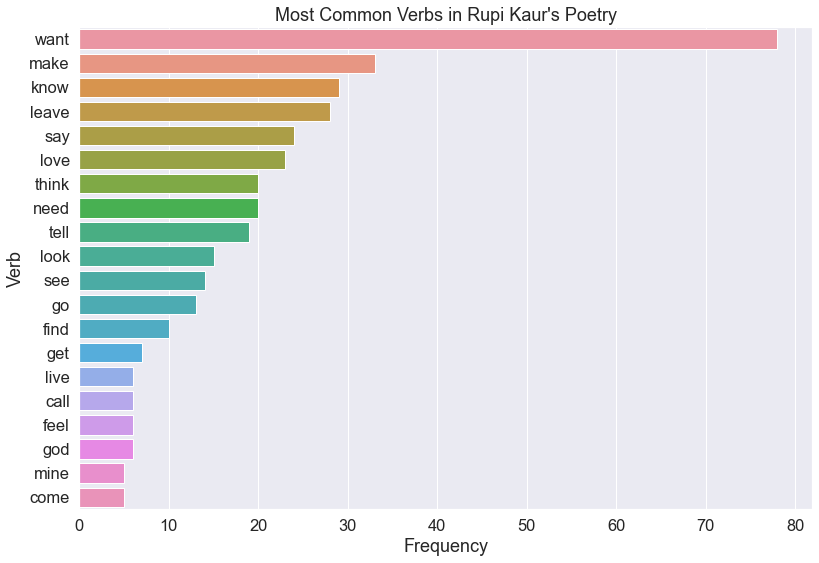

In [301]:
# Visualize word frequencies in a horizontal bar plot
sns.barplot(x = "Frequency",
            y = "Verb",
            data = verb_df,
            orient = "h").set_title("Most Common Verbs in Rupi Kaur\'s Poetry");

### What can verbs tell us?

Verbs and verb phrases are the action words of texts. They can tell us a lot about context of a sentence. I particularly like this description of the importance of verbs from <a href="https://literarydevices.net/verb/">Literary Devices</a>:

"*The most important role of a verb is that it provides a relationship with time. It, in fact, describes that something has happened, is happening, or will happen in the past, present or future respectively. Thus it puts a subject into action, and gives clarification about the subject and its meaning*"

Analyzing parts of speech is a very common activity when taking a close reading approach to literature. Yet, this distant reading allows us to clearly state, at least stastitically, which words and parts of speech Kaur engages with more than any others. 

That she uses 'want,' 'make,' and 'love' strengthens my ongoing reading that Kaur's work is interseted in themes of desire, creation, and love. Adding our noun frequency results, we might say that these actions are related to specific themes around womanhood,.



*(I don't know why it picked up 'god' as a verb phrase, but I do find it a bit fun)*



## Comparing Parts of Speech between collections

In [302]:
#defining a function that will tell us the percentage of parts of speeech in a string
def get_percentage_pos(string, pos):
    tokens = nltk.word_tokenize(string)
    tagged = nltk.pos_tag(tokens)
    matching_tagged = [word for word, p in tagged if pos == p]
    return len(matching_tagged) / len(tagged)

In [303]:
print("Milk and Honey has", '{:.2%}'.format(get_percentage_pos(milkhoney, "JJ")), "adjectives")
print("The Sun and Her Flowers has", '{:.2%}'.format(get_percentage_pos(sunflowers, "JJ")), "adjectives")
print("Homebody has", '{:.2%}'.format(get_percentage_pos(homebody, "JJ")), "adjectives")

Milk and Honey has 7.06% adjectives
The Sun and Her Flowers has 6.59% adjectives
Homebody has 6.58% adjectives


In [304]:
print("Milk and Honey has", '{:.2%}'.format(get_percentage_pos(milkhoney, "NN")), "nouns")
print("The Sun and Her Flowers has", '{:.2%}'.format(get_percentage_pos(sunflowers, "NN")), "nouns")
print("Homebody has", '{:.2%}'.format(get_percentage_pos(homebody, "NN")), "nouns")

Milk and Honey has 14.09% nouns
The Sun and Her Flowers has 16.67% nouns
Homebody has 17.47% nouns


In [305]:
print("Milk and Honey has", '{:.2%}'.format(get_percentage_pos(milkhoney, "VBP")), "verb phrases")
print("The Sun and Her Flowers has", '{:.2%}'.format(get_percentage_pos(sunflowers, "VBP")), "verb phrases")
print("Homebody has", '{:.2%}'.format(get_percentage_pos(homebody, "VBP")), "verb phrases")

Milk and Honey has 6.54% verb phrases
The Sun and Her Flowers has 4.86% verb phrases
Homebody has 6.05% verb phrases


## Analysis
Based on the above, the differences in percentages seem mostly negligible. Even though that's not super exciting, it does tell us that Rupi Kaur is pretty consistent across her three collections. 

Perhaps consistency in parts of speech percentages speaks to a degree of uniformity and sameness in Kaur's poetry overall. This at least tells us that she has a distinctive style and that she hasn't experimented much in terms of form (in so much as parts of speech are considered) in the seven years that she's been publishing.


# LDA Topic Modeling 

I used the <a href="https://github.com/dlab-berkeley/DIGHUM101-2021/tree/main/Notebooks/Week5">DH101 Week 5 Notebook</a> as my guide for how to define a bag of words, fit my data, and ultimately create my model. 

In [174]:
# Define an empty bag (of words)
vectorizer = CountVectorizer()

# Use the .fit method to tokenize the text and learn the vocabulary
vectorizer.fit(text_tokens)

CountVectorizer()

In [345]:
# Encode the documents
vector = vectorizer.transform(text_tokens)

print(type(vector))
print(vector.shape)
print(vector[:100]) 

<class 'scipy.sparse.csr.csr_matrix'>
(11783, 16)
  (4, 7)	1
  (5, 3)	1
  (16, 5)	1
  (37, 2)	1
  (42, 2)	1
  (58, 5)	1
  (65, 8)	1
  (67, 5)	1
  (77, 12)	1
  (83, 6)	1


In [176]:
# View as a multidimensional array before converting to data frame
# Rows are the documents, columns are the terms

print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [346]:
# Preview the terms

vectorizer.get_feature_names()[:10]

['book',
 'collection',
 'feel',
 'honey',
 'kaur',
 'like',
 'love',
 'milk',
 'one',
 'poems']

In [350]:
# number of topics
n_topics = 7

In [351]:
bigram_vectorizer = CountVectorizer(ngram_range = (1,2),
                                    stop_words = "english",
                                    token_pattern = r'\b\w+\b', 
                                    min_df = 1)

bigram_vectorizer

CountVectorizer(ngram_range=(1, 2), stop_words='english',
                token_pattern='\\b\\w+\\b')

In [352]:
# TfidfVectorizer to create the DTM
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90,
                                   max_features = 500,
                                   stop_words = "english")

# Fit
tfidf = tfidf_vectorizer.fit_transform(text_tokens)

In [353]:
# Analyze long_string in the bigram bag of words

analyze = bigram_vectorizer.build_analyzer()
vocab = analyze(expanded_string)

vocab[0:10]

['easy',
 'kind',
 'people',
 'asked',
 'milk',
 'honey',
 'dripped',
 'lips',
 'answered',
 'people']

In [354]:
# Instantiate our LDA model (this might take a minute or two)
lda = LatentDirichletAllocation(n_components = n_topics, 
                                max_iter = 20, 
                                random_state = 42)
lda = lda.fit(tfidf)

In [355]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx+1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [356]:
# Return the topics
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #1:
look, eyes, hands, come, water, living, took, lost, rest, little, kind, thought, knowing, magic, hear, word, half, point, instead, easy

Topic #2:
think, feel, mother, person, beautiful, right, sun, man, fingers, mouth, years, ask, parts, alive, seen, beauty, felt, soft, sure, second

Topic #3:
make, people, need, said, woman, mind, work, legs, good, entire, came, earth, head, looking, tired, makes, running, hand, words, worth

Topic #4:
home, thing, say, god, things, open, waiting, till, room, lips, wanted, better, father, takes, write, says, difficult, searching, family, knees

Topic #5:
life, know, leave, let, days, heart, end, skin, away, door, night, pain, comes, asked, hold, conversation, hurt, coming, thinking, free

Topic #6:
like, time, way, place, women, day, inside, flowers, live, feels, ones, going, turn, maybe, voice, tried, touched, idea, breathe, remember

Topic #7:
love, want, body, left, world, tell, long, hair, stay, feet, stop, new, friends, blood, trying,

In [357]:
panel = pyLDAvis.sklearn.prepare(lda_model = lda, 
                                 dtm = tfidf, 
                                 vectorizer = tfidf_vectorizer, 
                                 mds = "tsne")
pyLDAvis.display(panel)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


### What can these topics tell us?

The topics pulled from the model reveal a bit more to us about the text. To particular interest to me is the number of body parts that show up in the different topics. Topic 5, in particular, shows 'hands' and 'eyes' to be some of the most relevant terms. 

Although not within the scope of this project, I would be interested to see how bodies are fragmented in other works of poetry. 

## Vader Sentiment Analysis

 Valence Aware Dictionary for Sentiment Reasoning is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion

I used one of the previous student example projects, "Evaluating the Sentiment of Influential Texts" listed under 'Files' on the DH101 Bcourses website. I don't have a link to that student's notebook since it's relative to Bcourses access, but I can link <a href="http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html">this</a> VADER tutorial which th student used in development of their own code. 

Furthermore, the student's project used the VADER lexicon text file and more VADER information can be found from the <a href="https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt
">VADER sentiment github</a>



In [365]:
#make sure you're in the right directory 
os.chdir('/Users/hannahshlesinger/Desktop/DIGHUM101-2021-main/Final Project/Data')

In [366]:
vader_lex_df = pd.read_csv('vader_lexicon.txt', sep="\t", header=None) 
vader_lex_df.columns = ['word', 'polarity', 'junk', 'trash']
vader_lex_df = vader_lex_df.drop(['junk', 'trash'], axis=1)
#vader_lex_df.iloc[2000 : 2005]

#print("VADER thinks that there are around 7,000 words that can help quantify the sentiment of a sentence.")
vader_lex_df.describe()


,polarity
count,7520.000000
mean,-0.178923
std,1.703130
min,-3.900000
25%,-1.600000
50%,-0.500000
75%,1.500000
max,3.400000


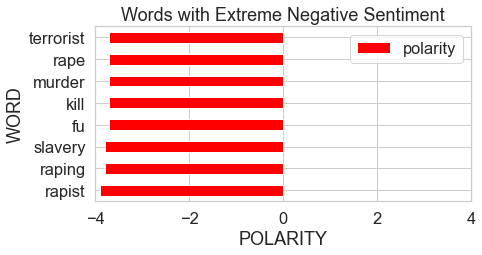

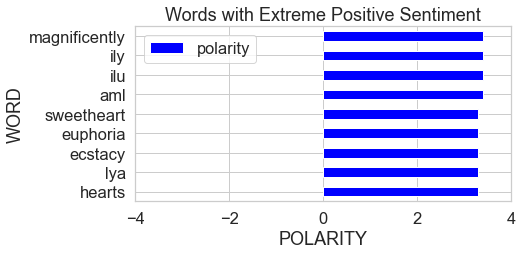

In [367]:
extreme_neg = (vader_lex_df[vader_lex_df['polarity']
                .agg(lambda x: (x <= -3.7))]
                .sort_values('polarity')
                .set_index("word"))

extreme_pos = (vader_lex_df[vader_lex_df['polarity']
                .agg(lambda x: (x >= 3.3))]
                .sort_values('polarity')
                .set_index("word"))

fig = extreme_neg.plot.barh(figsize=(6, 3), color = "red")
plt.xlim([-4, 4])
plt.xlabel("POLARITY")
plt.ylabel("WORD")
plt.title("Words with Extreme Negative Sentiment");
print()

fig = extreme_pos.plot.barh(figsize=(6, 3), color = "blue")
plt.xlim([-4, 4])
plt.xlabel("POLARITY")
plt.ylabel("WORD")
plt.title("Words with Extreme Positive Sentiment");

In [368]:
analyser = SentimentIntensityAnalyzer()
    

def avg_sentiment_rating(raw_text_str):
    """paramater: string representing either a single or many sentences
       return: an int representing the average sentiment rating
       of all the sentences contained in the entire text file"""
    return (pd.Series(sent_tokenize(raw_text_str))
                    .apply(sentence_sentiment_score)
                    .mean())


def most_polarized_sentence(raw_text_str, negative=False):
    """paramater: raw_text_str is a string representing either a single or many sentences,
       parameter: negative is a boolean
       return (negative=False): string which is the most positve sentence in the entire text file
       return (negative=True): string which is the most negative sentence in the text file"""
    sentences_ser = pd.Series(sent_tokenize(raw_text_str))
    sentiment_ratings = sentences_ser.apply(sentence_sentiment_score)
    zipped = list(zip(sentiment_ratings.index, sentiment_ratings))
    if negative:
        most_pos_tup = min(zipped, key=lambda x: x[1])
    else:
        most_pos_tup = max(zipped, key=lambda x: x[1])
    most_pos_sent = sentences_ser[most_pos_tup[0]]
    return most_pos_sent.replace("\n", " ");


# helper function
def sentence_sentiment_score(sentence_str):
    """parameter: string representing a single sentence
       return: the sentiment rating of sentence_str"""
    #print("{:-<40} {}".format(sentence, str(snt)))
    return analyser.polarity_scores(sentence_str)["compound"]
    

In [369]:
#This cell calculates sentiment_ratings in around 20 seconds then adds the sentiment_ratings
#to the existing DataFrame object text_df.

raw_text_ser = text_df["raw_text"]
sentiment_ratings = raw_text_ser.apply(avg_sentiment_rating)
text_df["sentiment_rating"] = sentiment_ratings
print("Add sentiment ratings to the DataFrame.")
text_df

Add sentiment ratings to the DataFrame.


,title,publish_date,raw_text,sentiment_rating
1,The Sun and Her Flowers,2017,bees came for honey\nflowers giggled as they\n...,0.115419
0,Milk and Honey,2014,how is it so easy for you\nto be kind to peopl...,0.079903
2,Homebody,2020,after feeling disconnected for so long\nmy m...,0.013190


In [370]:
print("Sentiment Rating Statistics")
text_df["sentiment_rating"].describe()

Sentiment Rating Statistics


count    3.000000
mean     0.069504
std      0.051902
min      0.013190
25%      0.046546
50%      0.079903
75%      0.097661
max      0.115419
Name: sentiment_rating, dtype: float64

## Rupi's Sentiment Rating

As you can tell from the compound score, Rupi's poetry is overall pretty positively coded. Given the most frequent words in her text, this isn't too surprising. Even though a close reading approach will reveal that many of Rupi's themes have to deal with difficult subjects, a distant reading approach gives a different perspective of her work as a system of words

In [371]:
punct_re = r'[^\w\s]'  # regex to remove punctuation
regex = re.compile(punct_re)
stop_words_lst = stopwords.words("english")
stemmer = PorterStemmer()


def most_common_words(text_str, N=10):
    """paramater: string of text
       return: list of tuples ("word", count)
       for the 10 most common words in raw_text"""
    clean_str = clean_by_word(text_str)
    return Counter(clean_str).most_common(N)  


# tokenize by word  
def clean_by_word(text_str):
    """parameter: string of text
       return: pandas Series of cleaned words
       function: splits on each word,
                 changes chars to lower, and words to stems
                 removes stop words and punctuation"""
    result = regex.sub(' ', text_str).lower()  # remove punc
    result = word_tokenize(result)  # break into list of words
    result = no_stops(result)  
    return stems(result) 
    

def stems(words_lst):
    """parameter: list of words
       return: list of stem words"""
    return pd.Series(words_lst).apply(stemmer.stem)


def no_stops(words_lst):
    """paramater: list of words
       return:  list of words with the stop words removed"""
    return [word for word in words_lst if word not in stop_words_lst]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


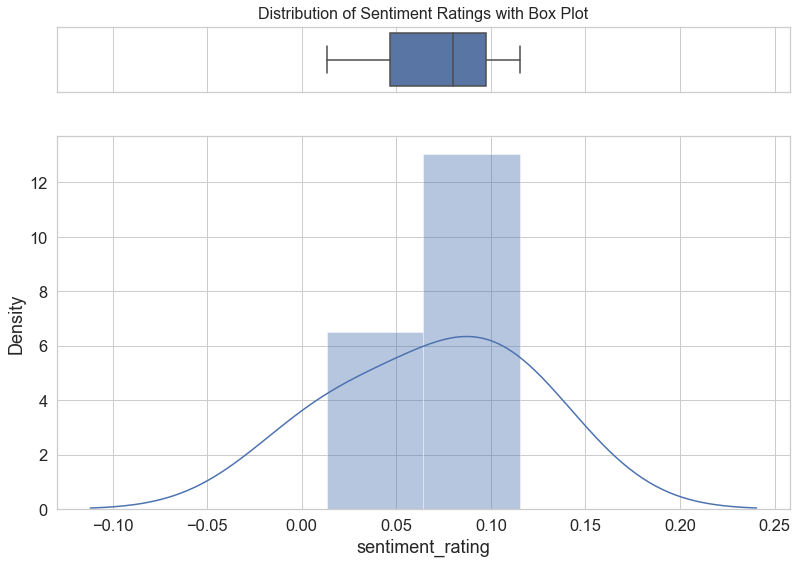

In [372]:
# Cut the window in 2 parts
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Add a graph in each part
fig = sns.boxplot(text_df["sentiment_rating"], ax=ax_box)
fig = sns.distplot(text_df["sentiment_rating"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Change figure size
fig = sns.set(rc={'figure.figsize':(5, 5)}) 

# Move title up on y axis
plt.title("Distribution of Sentiment Ratings with Box Plot", y=1.3, fontsize = 16);

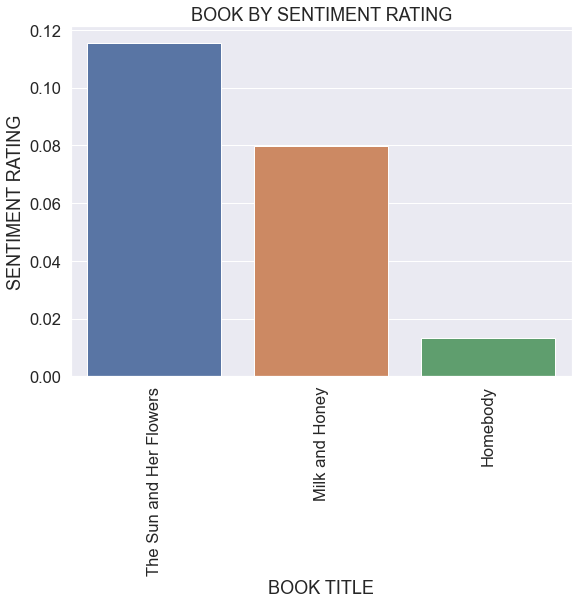

In [373]:
print()
text_df = text_df.sort_values(by="sentiment_rating", ascending=False)    
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(8, 6))
fig = sns.barplot(x="title", y='sentiment_rating', data=text_df)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("BOOK TITLE")
plt.ylabel("SENTIMENT RATING")
plt.title("BOOK BY SENTIMENT RATING");

### Analysis 

*Homebody* is signficantly more negatively rated than Rupi Kaur's other works. Kaur, in a few interviews, <a href="https://www.cbc.ca/radio/q/wednesday-dec-2-2020-rupi-kaur-meichi-ng-and-more-1.5823357/rupi-kaur-on-home-body-depression-and-the-viral-photo-that-changed-her-life-1.5823361">has mentioned </a> that *Home Body* was hard to publish because of the anxiety and depression she experienced after her skyrocket to fame. Of course, this information comes from paratext, but it is interesting to see these sentiments reflected in the actual scoring of her work. 

It's interesting that *The Sun and Her Flowers* is more positively rated than her first collection. Even so, all of her works are above 0.0, meaning they all, relative to the VADER lexicon, rank fairly positive. 

# Part 2: Sentiment Analysis of Reader Responses

## Scraping Goodreads Data

I used a webscraper from this Goodreads webscraper <a href='https://github.com/maria-antoniak/goodreads-scraper'>Github Repo</a> developed By <a href="https://github.com/melaniewalsh">Melanie Walsh</a> and <a href='https://https://github.com/maria-antoniak'>Maria Antoniak</a> to scrape Goodreads user ratings and reviews of Rupi Kaur's work 


You can navigate to my Final Project folder to access my Goodreads Scraped Data notebook which breaks down the process of converting the scraped reviews into a dataframe




In [374]:
os.chdir('/Users/hannahshlesinger/Desktop/DIGHUM101-2021-main/Final Project/goodreads-scraper-master')

In [375]:
goodreads_reviews_df = pd.read_csv('all_goodreads_reviews.csv')
goodreads_reviews_df.head(3)

,book_id_title,book_id,book_title,review_url,review_id,date,rating,user_name,user_url,text,num_likes,sort_order,shelves
0,35606560.the-sun-and-her-flowers,35606560,The Sun and Her Flowers,https://www.goodreads.com/review/show/2142763598,2142763598,2017-10-03,1.0,Megan,/user/show/72149944-megan,"I don't know where to begin. Listen, as a brow...",1664,default,[]
1,35606560.the-sun-and-her-flowers,35606560,The Sun and Her Flowers,https://www.goodreads.com/review/show/2152685049,2152685049,2017-10-14,3.0,Hailey (Hailey in Bookland),/user/show/21937982-hailey-hailey-in-bookland,*Thank you so much to Indigo for surprising me...,398,default,[]
2,35606560.the-sun-and-her-flowers,35606560,The Sun and Her Flowers,https://www.goodreads.com/review/show/2156632396,2156632396,2017-10-22,4.0,Julia Miller,/user/show/72672216-julia-miller,"Rupi, you have my heart ❤️ beautifully written...",276,default,[]


In [376]:
#uncomment to view the different columns in the data 
#goodreads_reviews_df.columns

In [377]:
#Get rid of some columns we don't need for analysis
columns = ['book_id_title', 'book_id','review_url','review_id','user_url','sort_order', 'shelves']
goodreads_reviews_df = pd.DataFrame(goodreads_reviews_df.drop(columns,axis=1,inplace=False))
goodreads_reviews_df.head(3)

,book_title,date,rating,user_name,text,num_likes
0,The Sun and Her Flowers,2017-10-03,1.0,Megan,"I don't know where to begin. Listen, as a brow...",1664
1,The Sun and Her Flowers,2017-10-14,3.0,Hailey (Hailey in Bookland),*Thank you so much to Indigo for surprising me...,398
2,The Sun and Her Flowers,2017-10-22,4.0,Julia Miller,"Rupi, you have my heart ❤️ beautifully written...",276


In [378]:
#how many reviews did each book receive?
print("Total Reviews per Book:","\n\n", 
      goodreads_reviews_df["book_title"].value_counts()[:3])

Total Reviews per Book: 

 Home Body                  300
Milk and Honey             180
The Sun and Her Flowers    150
Name: book_title, dtype: int64


## Analysis
I would have expected *Milk and Honey* to have the most reviews since it was published in 2014

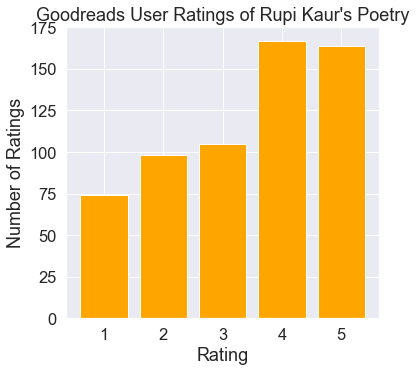

In [379]:
#Let's see how Rupi's work is rated overall 
rating_count=goodreads_reviews_df.groupby('rating').count()
plt.bar(rating_count.index.values, rating_count['book_title'],color='orange')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Goodreads User Ratings of Rupi Kaur\'s Poetry')
plt.show()

## Analysis
Kaur has the most 4 star ratings. It's hard to say how significant that average is without comparing it to other books on Gooodreads. Based on personal experience of the platform, a lot of book reviews average out to a 3 star rating, but I would need to actually pull the data to prove this.



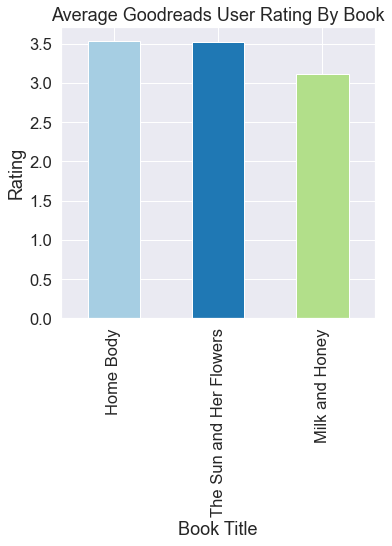

In [380]:
goodreads_reviews_df.groupby("book_title").rating.mean().sort_values(ascending=False)[:3].plot.bar(xlabel= "Book Title", 
                                                                                                  ylabel= "Rating",
                                                                                                  title="Average Goodreads User Rating By Book",
                                                                                                  color=plt.cm.Paired(np.arange(len(goodreads_reviews_df))),
                                                                                                  figsize=(5,5))
plt.show()





### What about likes?

the graphs above to factor in the number of likes each review and rating got. It's hard to know what a user intends when the 'like' another user's review because another user's review could contain a written review and a rating or just a rating. Therefore, you don't know if they're agreeing or liking the content of the review or simply the numerical value of the rating. 

Let's plot the number of likes with the number of ratings to see how many likes each rating got for each book. 

([<matplotlib.axis.XTick at 0x12c7d34f0>,
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4')])

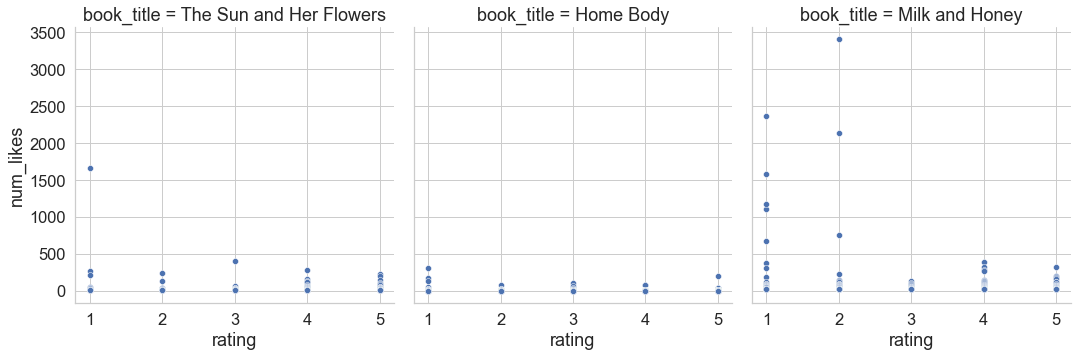

In [382]:
graph = sns.relplot(
    data=goodreads_reviews_df,
    x="rating", y="num_likes", col="book_title",
)

#changed x value range to integers since Goodreads ratings can only be integers
plt.xticks(range(1,6))




In [383]:
#%%time
#This cell calculates sentiment_ratings in around 20 seconds then adds the sentiment_ratings
#to the existing DataFrame object goodreads_reviews_df.

raw_text_ser = goodreads_reviews_df["text"]
sentiment_ratings = raw_text_ser.apply(avg_sentiment_rating)
goodreads_reviews_df["sentiment_rating"] = sentiment_ratings
print("Add sentiment ratings to the DataFrame.")
goodreads_reviews_df.head()

Add sentiment ratings to the DataFrame.


,book_title,date,rating,user_name,text,num_likes,sentiment_rating
0,The Sun and Her Flowers,2017-10-03,1.0,Megan,"I don't know where to begin. Listen, as a brow...",1664,0.105078
1,The Sun and Her Flowers,2017-10-14,3.0,Hailey (Hailey in Bookland),*Thank you so much to Indigo for surprising me...,398,0.264217
2,The Sun and Her Flowers,2017-10-22,4.0,Julia Miller,"Rupi, you have my heart ❤️ beautifully written...",276,0.836000
3,The Sun and Her Flowers,2017-11-09,1.0,Brittney Andrews (beabookworm),This review was brought to you by the best Rea...,266,0.046131
4,The Sun and Her Flowers,2019-05-19,2.0,JV (semi-hiatus),"Once, there were these poems,Which my heart ca...",236,0.205671


In [384]:
#defining some new functions for our new data set
#again these were developed by the Evaluating Sentiment Analysis of Popular Texts Notebook

def avg_sentiment_rating(review_raw_text_str):
    """paramater: string representing either a single or many sentences
       return: an int representing the average sentiment rating
       of all the sentences contained in the entire text file"""
    return (pd.Series(sent_tokenize(review_raw_text_str))
                    .apply(sentence_sentiment_score)
                    .mean())


def most_polarized_sentence(review_raw_text_str, negative=False):
    """paramater: raw_text_str is a string representing either a single or many sentences,
       parameter: negative is a boolean
       return (negative=False): string which is the most positve sentence in the entire text file
       return (negative=True): string which is the most negative sentence in the text file"""
    sentences_ser = pd.Series(sent_tokenize(review_raw_text_str))
    sentiment_ratings = sentences_ser.apply(sentence_sentiment_score)
    zipped = list(zip(sentiment_ratings.index, sentiment_ratings))
    if negative:
        most_pos_tup = min(zipped, key=lambda x: x[1])
    else:
        most_pos_tup = max(zipped, key=lambda x: x[1])
    most_pos_sent = sentences_ser[most_pos_tup[0]]
    return most_pos_sent.replace("\n", " ");


# helper function
def sentence_sentiment_score(sentence_str):
    """parameter: string representing a single sentence
       return: the sentiment rating of sentence_str"""
    #print("{:-<40} {}".format(sentence, str(snt)))
    return analyser.polarity_scores(sentence_str)["compound"]

In [388]:
book_titles = goodreads_reviews_df["book_title"]
review_raw_texts = goodreads_reviews_df["text"]

print("The most positive sentences in reviews are:")
print()
for i in range(i):
    print(book_titles[i])
    print(most_polarized_sentence(review_raw_texts[i],))
    print()

print()
print()
print("The most negative sentences in the first few reviews are:")
print()
for i in range(i):
    print(book_titles[i])
    print(most_polarized_sentence(review_raw_texts[i], negative=True))
    print()

The most positive sentences in reviews are:

The Sun and Her Flowers
Furthermore, I just can't ignore the more popular pieces she has claimed as her own when any avid reader can tell you they are not.

The Sun and Her Flowers
But, I liked the fact that this collection dealt with femininity, immigration, and self love.

The Sun and Her Flowers
Rupi, you have my heart ❤️ beautifully written and ohhh the art :‘)



The most negative sentences in the first few reviews are:

The Sun and Her Flowers
Being critical is simply tough love - so don't be so quick to dismiss my negative feeback.First of all, half of this book are one-liners from her first book, and most of her longer pieces felt lazy and ill-thought out.

The Sun and Her Flowers
Not sure if I'll now pick up Milk & Honey.



### Analysis
So, this code isn't perfect and I was using the student model as an example. As you can tell a sentence like the first printed review isn't actually positive. 

That review is noting that Rupi Kaur has been accused of plagirism of other online poets. Yet, the sentiment score can't pick up on the nuance of this critique because of the compound sentiment rating of the sentence based on the individual words. 

This is a good reminder that it's important to contextualize your data and analysis. The data can't tell us everything, but the fact that this kind of output might generate questions does allow for further improvement of the code as well to ask questions that might lead to further investigation. 

If you're interested in the plagirism accusations, please see <a href='https://www.distractify.com/p/rupi-kaur-plagiarism'>this article.</a> 

In [389]:
print("Sentiment Rating Statistics")
goodreads_reviews_df["sentiment_rating"].describe()


Sentiment Rating Statistics


count    630.000000
mean       0.242508
std        0.290615
min       -0.924700
25%        0.054621
50%        0.239145
75%        0.411158
max        0.955700
Name: sentiment_rating, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


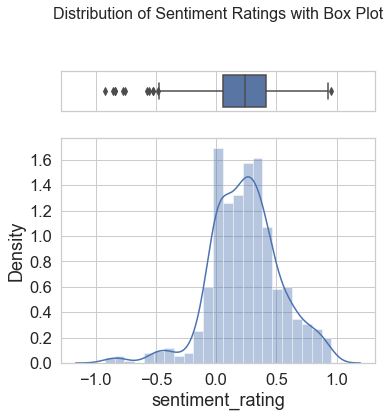

In [390]:
# Cut the window in 2 parts
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Add a graph in each part
fig = sns.boxplot(goodreads_reviews_df["sentiment_rating"], ax=ax_box)
fig = sns.distplot(goodreads_reviews_df["sentiment_rating"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Change figure size
fig = sns.set(rc={'figure.figsize':(11.7, 8.27)}) 

# Move title up on y axis
plt.title("Distribution of Sentiment Ratings with Box Plot", y=1.5, fontsize = 16);

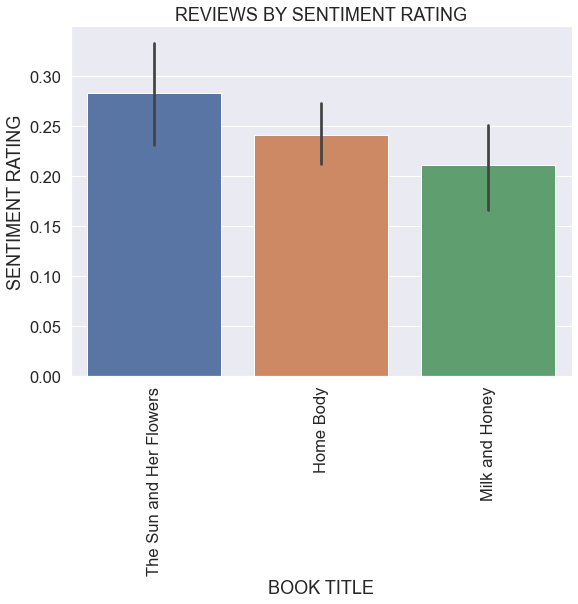

In [391]:
print()
goodreads_reviews_df = goodreads_reviews_df.sort_values(by="sentiment_rating", ascending=False)    
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(8, 6))
fig = sns.barplot(x="book_title", y='sentiment_rating', data=goodreads_reviews_df)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("BOOK TITLE")
plt.ylabel("SENTIMENT RATING")
plt.title("REVIEWS BY SENTIMENT RATING");



### Analysis

It's interesting that *Homebody*, the most negatively scored text has the most positively ranked reviews. My guess this has to do with the publish date and popularity of Kaur's work. *Homebody* was published in 2020 which means it has most likely reached readers who have been anticipating it and pre-existing followers of her work. Such a demographic is naturally going to rank her work higher. Furthermore, since this is her third collection, all the readers who disliked and rated and her reviewed her work negatively wouldn't have incentive to pick up her most recent collection. 

However, assuming Rupi Kaur continues to publish work, I woouldn't be surprised if the sentiment rating for *Homebody* went down over time. 

# Word frequency visualization

Maybe the most common words in the reviews can shed insight on how people felt about Kaur's work. 

In [236]:
review_string = ','.join(goodreads_reviews_df['text'].values)

#remove punctuation
for char in punctuation:
    review_string = review_string.replace(char, "")
    
#remove contractions
expanded_words = []    
for word in review_string.split():
 # using contractions.fix to expand the shotened words
  expanded_words.append(contractions.fix(word))   
    
expanded_review_string = ' '.join(expanded_words)

#make lowercase
expanded_review_string = expanded_review_string.lower()

#remove digits using regex

digits = r'[0-9]'

final_string = re.sub(digits, '', expanded_review_string)

final_string[:500]


'i am not a massive fan of poetry but rupi kaur has a way of words and she puts things that we understand and makes the words beautiful and enchantingi loved the poems in this book and i loved the writing style too ✨some of these were really beautiful and touching 💛 just feel like a lot were just filler bec she was probably pushed to publish something else wish there would have been more development and more longer poems in herewriting heals this is exactly what rupi did she did not only heal her'

In [392]:
#Tokenize the string
gr_tokens = final_string.split()

# Remove stopwords
stop = stopwords.words("english")
no_stops = [word for word in gr_tokens if word not in stopwords.words('english')]
freq_gr = Counter(no_stops)

# Print the 10 most common words
gr_df = pd.DataFrame(freq_gr.most_common(16), columns = ["Word", "Frequency"])


gr_df.head()

,Word,Frequency
0,poetry,650
1,book,602
2,poems,540
3,like,529
4,love,398


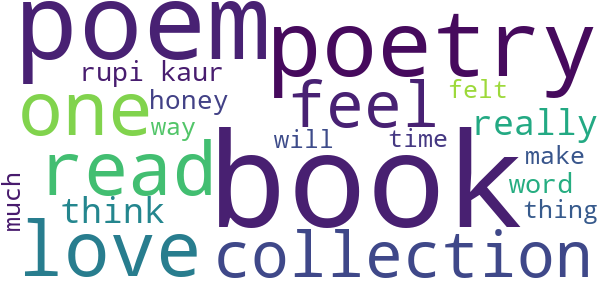

In [393]:
# Define a word cloud variable
cloud = WordCloud(background_color = "white", 
                  max_words = 20, 
                  contour_width = 5, 
                  width = 600, height = 300, 
                  random_state = 42)

# Process the word cloud
cloud.generate(final_string)

# Visualize!
cloud.to_image()

### Huh 

These words are pretty unhelpful...

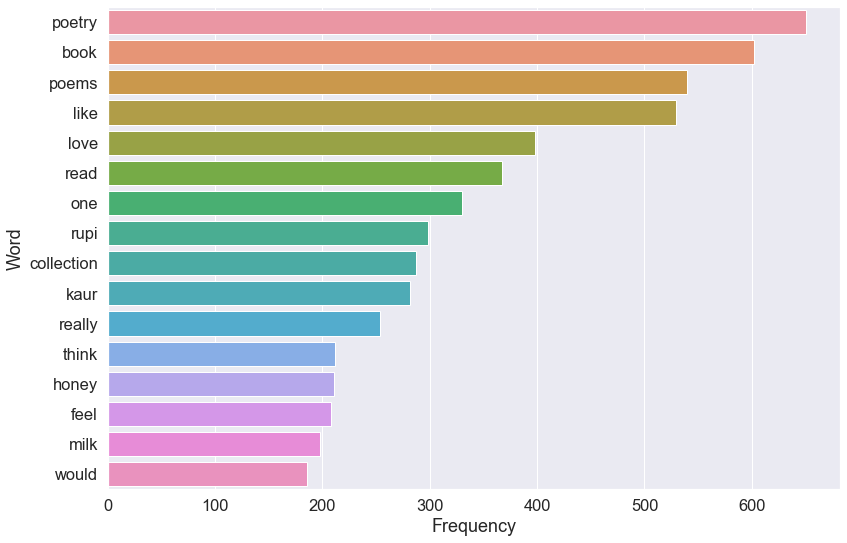

In [394]:
# Visualize word frequencies in a horizontal bar plot

sns.barplot(x = "Frequency",
            y = "Word",
            data = gr_df,
            orient = "h",);

### Analysis

Alright, so these are expected words, but they don't tell us as much about how readers felt. So far, the sentiment analysis is the most useful. Perhaps we can use LDA topic modeling of reviews to get a better sense of the themes within the reviews. I imagine they may mirror the text themselves, but let's find out. 

## LDA Topic modeling of Goodreads Reviews
The top words didn't really reveal a lot to us about the themes that popped up in the reviews, so let's try topic modeling to see if we can generate something a little more informative

In [269]:
# Define an empty bag (of words)
vectorizer = CountVectorizer()

# Use the .fit method to tokenize the text and learn the vocabulary
vectorizer.fit(gr_df["Word"])

CountVectorizer()

In [395]:
# Encode the documents
vector = vectorizer.transform(gr_df["Word"])

print(type(vector))
print(vector.shape)
print(vector[:100]) 

<class 'scipy.sparse.csr.csr_matrix'>
(16, 16)
  (0, 10)	1
  (1, 0)	1
  (2, 9)	1
  (3, 5)	1
  (4, 6)	1
  (5, 11)	1
  (6, 8)	1
  (7, 13)	1
  (8, 1)	1
  (9, 4)	1
  (10, 12)	1
  (11, 14)	1
  (12, 3)	1
  (13, 2)	1
  (14, 7)	1
  (15, 15)	1


In [396]:
# View as a multidimensional array before converting to data frame
# Rows are the documents, columns are the terms

print(vector.toarray())

[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [397]:
# Preview the terms

vectorizer.get_feature_names()[0:10]

['book',
 'collection',
 'feel',
 'honey',
 'kaur',
 'like',
 'love',
 'milk',
 'one',
 'poems']

In [273]:
# What other processing steps could you include here
# ... instead of doing them manually above? 

bigram_vectorizer = CountVectorizer(ngram_range = (1,2),
                                    stop_words = "english",
                                    token_pattern = r'\b\w+\b', 
                                    min_df = 1)

bigram_vectorizer

CountVectorizer(ngram_range=(1, 2), stop_words='english',
                token_pattern='\\b\\w+\\b')

In [278]:
# Analyze long_string in the bigram bag of words

analyze = bigram_vectorizer.build_analyzer()
vocab = analyze(final_string)

vocab[:10]

['massive',
 'fan',
 'poetry',
 'rupi',
 'kaur',
 'way',
 'words',
 'puts',
 'things',
 'understand']

In [279]:
# Predetermine the number of topics

n_topics = 7
# n_topics = 20

In [280]:
# TfidfVectorizer to create the Data term matrix
#DTM displays term frequencies or TFIDF scores across documents 
#column headers can be read as (document number, term) frequency
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90,
                                   max_features = 500,
                                   stop_words = "english")

# Fit
tfidf = tfidf_vectorizer.fit_transform(gr_tokens)

In [281]:
# Instantiate our LDA model (this might take a minute or two)
lda = LatentDirichletAllocation(n_components = n_topics, 
                                max_iter = 20, 
                                random_state = 42)
lda = lda.fit(tfidf)

In [282]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx+1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [283]:
# Return the topics
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #1:
love, honey, think, know, life, want, lot, make, enjoyed, healing, makes, times, maybe, loving, tell, trauma, sense, idea, appreciate, sex

Topic #2:
rupi, writing, people, time, things, written, liked, little, review, going, short, author, world, experience, parts, important, sections, sexual, best, come

Topic #3:
read, felt, poem, work, topics, sun, thing, better, feminism, actually, powerful, feeling, depression, relationships, end, line, woman, story, art, anxiety

Topic #4:
poetry, book, feel, heart, loved, home, flowers, thought, personal, rest, stars, themes, sure, recommend, especially, left, touched, comes, relatable, beauty

Topic #5:
like, kaur, did, women, style, need, kind, que, feels, illustrations, definitely, page, person, feelings, bit, pieces, long, issues, emotions, lines

Topic #6:
just, collection, really, milk, reading, body, beautiful, good, does, kaurs, abuse, self, new, thoughts, look, raw, pages, deep, quite, pretty

Topic #7:
poems, words, way, bo

In [284]:
panel = pyLDAvis.sklearn.prepare(lda_model = lda, 
                                 dtm = tfidf, 
                                 vectorizer = tfidf_vectorizer, 
                                 mds = "tsne")
pyLDAvis.display(panel)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


### Analysis

Again, while the 'top' listed words aren't super useful, the overall topics are more helpful to us. Key words like 'appreciate,' 'favorite,' 'powerful,' 'sexual' tell us some more about how people felt. Of course we still don't have full context. It's easy to see some words like this and assume positive context. 

However, these words could also be in the context of reviews that are written 'I didn't appreciate' or 'Not my favorite'

# Further Investigation:
    
## Bigger and more diverse data set
As mentioned in the outset, I wanted to get more data from social media to gather a sense of discourse around Rupi Kaur's work. I ultimately limited scope to Goodreads since I knew for certain that discourse in the text of reviews would be a response to her work as well as Kaur herself whereas social media posts would be harder to filter for specific content. In the future, I would like to spend more time parsing through social media data, specifically Instagram, YouTube, and Twitter. I think I would also take formal reviews from magazines and newspapers to see how the language compares between 'low' and 'high' reviews

## Visual analysis 
In addition, I believe there is a lot to be analyzed in regards to the visual elements of Kaur's works. I ultimately decided to stay within the scope of textual analysis, but I believe overall analysis of her work wouldn't be complete without taking her illustrations and text placement on the page into consideration.

### Classification Model:
Create classification model to compare Kaur’s work to other contemporary and “insta-poets”

A classification model may also be useful for testing and understanding the degree of similarity to the tumblr poets whose work Rupi Kaur was accused of plagirism. As more people post poetry online, it can be harded to differentiate between original and plagirised content. Intellectual property disputes are a huge issue with the expansion of social media and is definitely worth exploring more. 

# Conclusions

Rupi Kaur’s poetry is relatively uniform in terms of parts of speech across her three collections. As per my initial assumptions, a lot of the common themes, based on models and word frequencies, seem to be focused on themes of love, desire, the body, and womanhood. In general, her work is relatively positively scored, with *Homebody* standing out as relatively more negative compared to her first two collections. 

According to Goodreads reviews and it ratings, it would seem readers mostly have a positive response to Rupi Kaur's work. However, the community response to other users' reviews, as denoted by 'number of likes' on reviews, skews the data revealing that perhaps the sentiment is more negative than the data shows on the surface. 

Ultimately, data can provide interesting new insight, but it can't tell us everything. I think the way we talk about books is definiely shaped by community response, so it would be interesting to look more into that going forward with my investigation. 







### Credits & Acknowledgements

This code in this notebook draws support from many different sources. The main sources of code and tuorials are linked in their respective sections, but I would also like to extend thanks to Dr Brooks Jessup, Dr Adam Anderson, and Ash Tan for their assistance in developing coding skills that made this exploration in computational text analysis possible